## Data Pre-Process

### Import Data and Create Column Names
1. Import data as a table
2. Add column names into the table

In [77]:
T = readtable('C:\Users\jerem\Documents\Python Scripts\Scania\clean_data.csv');

T.Properties.VariableNames = {'KVSV1', 'OTGT1', 'OTGT6', 'OTSV1', 'QV11', 'TV11', 'TV12', 'TV_Cmd'};

### Create mini batch
The size of the mini batch is taken every 5000th sample due to the large dataset <br>
> Input Command: TV_Cmd    <br>
> Input 3-way valve: OTSV1 <br>
> Output Temp: TV12        <br>

### Partation of training and testing dataset
Currently the size is $\frac{train}{test} = \frac{1}{1}$

In [78]:
mini_batch_train = T(1:5000:end, :);
mini_batch_test  = T(2:5000:end, :);

u_train = table2array(mini_batch_train(:, 4));   % OTSV1
y_train = table2array(mini_batch_train(:, 7));   % TV12

u_test = table2array(mini_batch_test(:, 4));   % OTSV1
y_test = table2array(mini_batch_test(:, 7));   % TV12

### Create iddata object for Training and Testing
data = iddata(*input*, *ouput*, *sampling time*)

**Sampling Time** <br>
Since the data size is too big, the partation of training and testing data is taken every 5000 sample. <br>
Which means the sampling time of the mini dataset is 0.002*5000 = 10 seconds <br>

In [79]:
Ts = 10;   % 2ms

In [80]:
%% Training Data
data_train = iddata(y_train, u_train, Ts);

data_train.Name = 'mini_batch_train';
data_train.TimeUnit = 'seconds';

data_train.InputName = 'OTSV1';   data_train.InputUnit = 'Percentage';
data_train.OutputName = 'TV12';   data_train.OutputUnit = 'Celsius';

%% Testing Data
data_test = iddata(u_test, y_test, Ts);

data_test.Name = 'mini_batch_test';
data_test.TimeUnit = 'seconds';

data_test.InputName = 'OTSV1';   data_test.InputUnit = 'Percentage';
data_test.OutputName = 'TV12';   data_test.OutputUnit = 'Celsius';

%% Print Data
get(data_train)


ans = 

  struct with fields:

              Domain: 'Time'
                Name: 'mini_batch_train'
          OutputData: [323x1 double]
                   y: 'Same as OutputData'
          OutputName: {'TV12'}
          OutputUnit: {'Celsius'}
           InputData: [323x1 double]
                   u: 'Same as InputData'
           InputName: {'OTSV1'}
           InputUnit: {'Percentage'}
              Period: Inf
         InterSample: 'zoh'
                  Ts: 10
              Tstart: []
    SamplingInstants: [323x0 double]
            TimeUnit: 'seconds'
      ExperimentName: 'Exp1'
               Notes: {}
            UserData: []




### Check Nonlinearity

In [6]:
advice(data_train, 'nonlinearity')

There is an indication of nonlinearity in the data.
A nonlinear ARX model of order [4 4 1] and treepartition nonlinearity estimator 
performs better prediction of output than the corresponding ARX model of the 
same order. Consider using nonlinear models, such as IDNLARX, or IDNLHW. You 
may also use the "isnlarx" command to test for nonlinearity with more options.




### Plot Input-Output

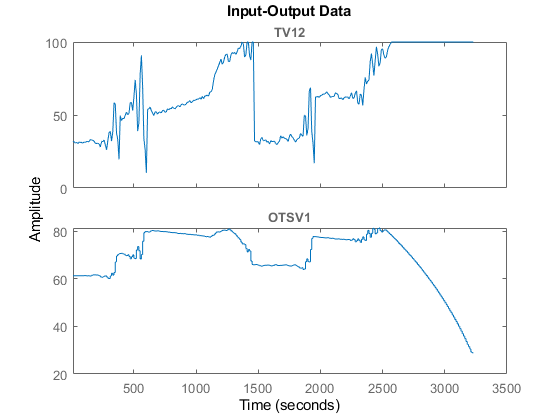

In [7]:
plot(data_train)

The last part of the data seems werid because the heating valve is still heating up. So remove the part after 0.5 sec

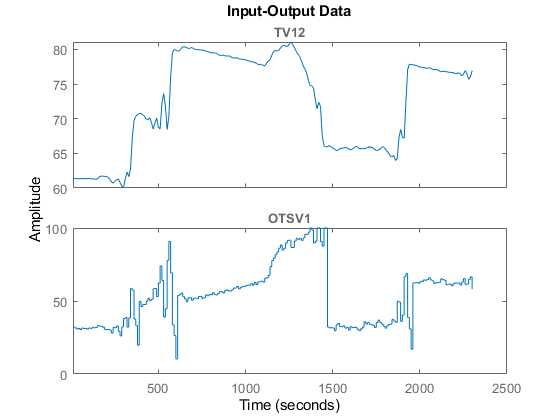

In [81]:
data_train = data_train(1:230);
plot(data_train)

## System Identification: Transfer Function Model

sysTF = tfest(*data*, *Num of Poles*, *Num of Zeros*)

### Set estimation options

In [35]:
opt = tfestOptions;
opt.InitializeMethod = 'all';
opt.SearchOptions.MaxIterations = 60; 
opt.Display = 'on';

### Estimate TF model

In [36]:
np = 5;          % Num of pole
nz = 4;          % Num of zero
iodelay = 20.0;   % In/Out delay

sysTF = tfest(data_train, np, nz, opt)


sysTF =
 
  From input "OTSV1" to output "TV12":
   1.411e-07 s^4 + 6.021e-05 s^3 + 8.508e-06 s^2 - 1.18e-09 s + 1.435e-10
  ------------------------------------------------------------------------
  s^5 + 0.1635 s^4 + 0.06308 s^3 + 4.326e-05 s^2 + 1.031e-06 s + 9.164e-11
 
Continuous-time identified transfer function.

Parameterization:
   Number of poles: 5   Number of zeros: 4
   Number of free coefficients: 10
   Use "tfdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using TFEST on time domain data "mini_batch_train".
Fit to estimation data: 58.52%                               
FPE: 9.413, MSE: 8.261                                       



### Advice on the estimated model

In [18]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Error Analysis Transfer Function Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [37]:
% generate reference output
y_tf_ref = data_train.y;

% generate estimated output
y_tf_est = sim(sysTF, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_tf_est.y, y_tf_ref, cost_func)


fit =

    9.4395




#### Compare

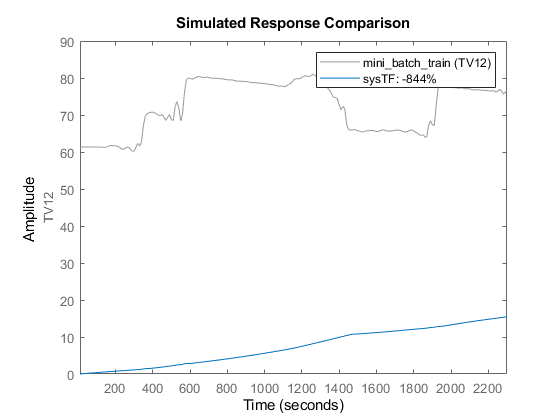

In [38]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysTF, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

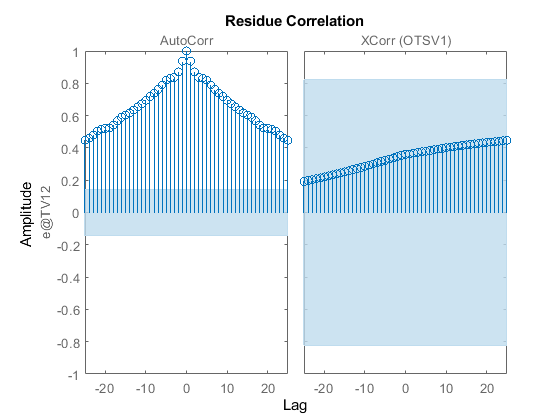

In [15]:
resid(data_test,sysTF)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

## System Identification: Process Model

A process model can go up to a max 3rd-order <br>
* $P1D = \frac{K_p}{1+T_{p1}s} e^{-T_{d}s}$ (1st order) <br>
* $P2D = \frac{K_p}{(1+T_{p1}s)(1+T_{p2}s)} e^{-T_{d}s}$ (2nd order)<br>
* $P3D = \frac{K_p}{(1+T_{p1}s)(1+T_{p2}s)(1+T_{p3}s)} e^{-T_{d}s}$ (3rd order)<br>
> $K_p$: proportional gain <br>
> $T_{p1}, T_{p2}, T_{p3}$: time constant of the real pole <br>
> $T_{d}$: transport delay <br>

sysPXD = tfest(*data*, *'PXD*')

### Set estimation options ([link](https://se.mathworks.com/help/ident/ref/procestoptions.html))
Disturbance Model
> $y = G(s)u + H(s)e$ <br>
* none — $H$ is fixed to one <br>
* estimate: $H$ is treated as an estimation parameter. The software uses the value of the NoiseTF property as the initial guess <br>
* ARMA1: The software estimates $H$ as a 1st-order ARMA model <br>
> $\frac{1+cs}{1+ds}$ <br>
* ARMA2: The software estimates $H$ as a 2nd-order ARMA model <br>
> $\frac{1+c_{1}s+c_{2}s^{2}}{1+d_{1}s+d_{2}s^{2}}$ <br>
* fixed: The software fixes the value of the NoiseTF property of the idproc model as the value of $H$ <br>

In [86]:
opt = procestOptions;
opt.DisturbanceModel = 'ARMA1';
opt.Focus = 'prediction';

### Set system initial condition ([link](https://se.mathworks.com/help/ident/ref/idproc.html), [heatExchangerExample](https://se.mathworks.com/help/ident/ug/estimating-transfer-function-models-for-a-heat-exchanger.html))

In [88]:
sysInit = idproc('P1D');
sysInit.TimeUnit    = 'seconds';
sysInit.Structure.Kp.Value    = 1;
sysInit.Structure.Kp.Minimum  = 0;
sysInit.Structure.Tp1.Value   = 1;
sysInit.Structure.Tp1.Maximum = 10;
sysInit.Structure.Td.Value    = 0.2;
sysInit.Structure.Td.Minimum  = 0;
sysInit.Structure.Td.Maximum  = 1;

### Estimate Process model

In [89]:
sysP1D = procest(data_train, 'P1D')


sysP1D =
Process model with transfer function:
             Kp                      
  G(s) = ---------- * exp(-Td*s)     
          1+Tp1*s                    
                                     
        Kp = 1.2044                  
       Tp1 = 1e-06                   
        Td = 0                       
                                     
Parameterization:
    {'P1D'}
   Number of free coefficients: 3
   Use "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                        
Estimated using PROCEST on time domain data "mini_batch_train".
Fit to estimation data: -227%                                  
FPE: 527.1, MSE: 513.5                                         



### Advice on the estimated model

In [90]:
advice(sysP1D, data_test)

                                                                                                                                                                                                                                                                                                                              
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                                                              
A first general advice is to run RESID(VDAT

### Error Analysis Transfer Function Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [91]:
% generate reference output
y_Pro_ref = data_train.y;

% generate estimated output
y_Pro_est = sim(sysP1D, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_Pro_est.y, y_Pro_ref, cost_func)


fit =

    3.2701




#### Compare

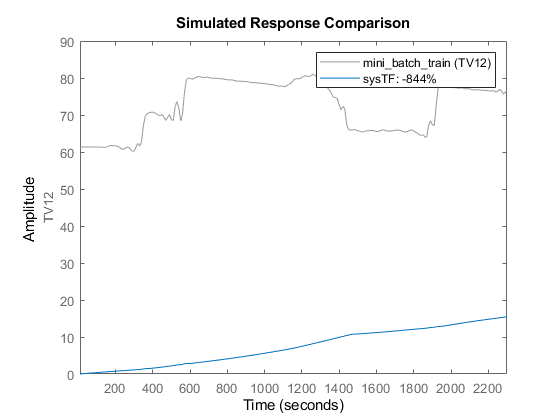

In [92]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysTF, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

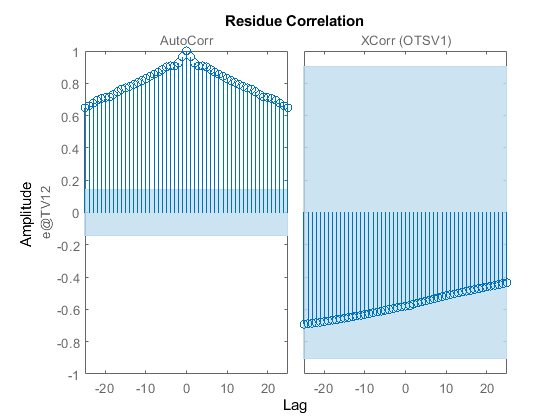

In [94]:
resid(data_test,sysP1D)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

The Final Prediction Error analysis is already done in tfest, ssest, etc.

## System Identification: State Space Model

sysSS = ssest(*data*, *Num of Poles*, *Num of Zeros*)

### Set estimation options

### Estimate SS model
For state space model, there are two ways of determining the system order <br>
1. **By specifying the system order with paramter $nx$ with custom estimation options**
2. Don't specify it. The program will automatically find the best order with least error

In [32]:
sysSS = ssest(data_train)


sysSS =
  Continuous-time identified state-space model:
      dx/dt = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
              x1         x2
   x1   0.001329   0.002314
   x2  -0.002604   -0.01596
 
  B = 
            OTSV1
   x1  -1.065e-05
   x2   0.0001077
 
  C = 
             x1      x2
   TV12  -246.9  -2.038
 
  D = 
         OTSV1
   TV12      0
 
  K = 
           TV12
   x1  -0.00074
   x2  0.001855
 
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 10
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using SSEST on time domain data "mini_batch_train".
Fit to estimation data: 90.37% (prediction focus)            
FPE: 0.4779, MSE: 0.4457                                     



### Estimate SS model
For state space model, there are two ways of determining the system order <br>
1. By specifying the system order with paramter $nx$ with custom estimation options
2. **Don't specify it. The program will automatically find the best order with least error**

### Estimate SS model with order selection ([link](https://se.mathworks.com/help/ident/ug/estimate-state-space-model-with-order-selection.html))
There different functions can be used here. **n4sid** & **ssregest** construct a discrete-time model, **ssest** constructs a continuous-time model <br>
1. n4sid(data, n1:n2)
> n1:n2 is the range of orders to try <br>
> Ex. model = n4sid(data, n1:n2)

2. ssest(data, nn)
> nn is the range of orders to try     <br>
> Ex. model = ssest(data, nn, 'Ts', data.Ts) <br>

3. ssregest(data, nn)
> nn is the range of orders to try     <br>
> Ex. model = ssregest(data, nn, 'Ts', data.Ts) <br>




In [73]:
nn = [1, 2, 3, 4, 5, 6, 7, 8];
%sysSS = ssest(data_train, nn, 'Ts', data_train.Ts)
%sysSS = ssregest(data_train, nn, 'Ts', data_train.Ts)
sysSS = n4sid(data_train, 1:8)


sysSS =
  Discrete-time identified state-space model:
    x(t+Ts) = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
             x1        x2        x3
   x1     1.004  -0.02546   0.02861
   x2  -0.02761    0.7638    0.5386
   x3   -0.1609   -0.5376   0.04398
 
  B = 
            OTSV1
   x1  -4.344e-06
   x2   0.0003812
   x3    -0.00491
 
  C = 
             x1      x2      x3
   TV12  -260.2   2.182  -1.994
 
  D = 
         OTSV1
   TV12      0
 
  K = 
            TV12
   x1  -0.004312
   x2    0.03433
   x3    0.02706
 
Sample time: 10 seconds
  
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 18
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using N4SID on time domain data "mini_batch_train".
Fit to estimation data: 87.07% (prediction focus)      

In [65]:
opt = ssestOptions;
opt.InitializeMethod = 'auto';
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 50; 
opt.Display = 'on';

In [66]:
nx = 3
sysSS = ssest(data_train, nx, opt)


nx =

     3


sysSS =
  Continuous-time identified state-space model:
      dx/dt = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
               x1          x2          x3
   x1  -0.0008715    0.001278    0.006774
   x2    -0.02054     0.04922      0.1561
   x3     0.04482     -0.1753     -0.2603
 
  B = 
            OTSV1
   x1  -1.383e-05
   x2  -0.0004332
   x3    0.001174
 
  C = 
             x1      x2      x3
   TV12   292.3  -2.848   2.609
 
  D = 
         OTSV1
   TV12      0
 
  K = 
           TV12
   x1  0.001269
   x2  0.007005
   x3   -0.0228
 
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 18
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using SSEST on time domain data "mini_batch_train".
Fit to estimation data: 89.96% (prediction fo

### Advice on the estimated model

In [50]:
advice(sysSS, data_test)

                                                                                                                                                                                                                                           
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysSS.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysSS = pem(sysSS, mini_batch_train, Options)              
                                                                                                                                                                                                                                           
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                             
                                                        

### Error Analysis State Space Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [74]:
% generate reference output
y_ss_ref = data_train.y;

% generate estimated output
y_ss_est = sim(sysSS, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_ss_est.y, y_ss_ref, cost_func)


fit =

   24.9885




#### Compare

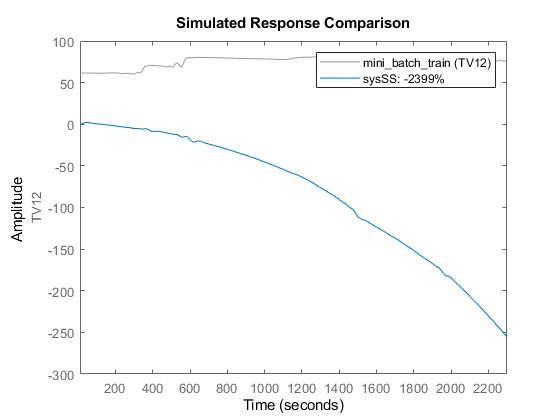

In [75]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysSS, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

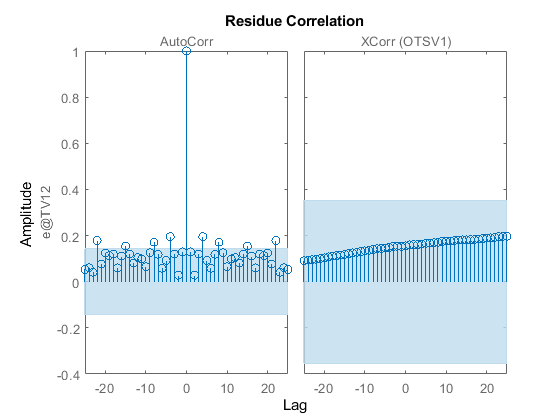

In [35]:
resid(data_test,sysSS)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

The Final Prediction Error analysis is already done in tfest, ssest, etc.

## System Identification: ARX Model

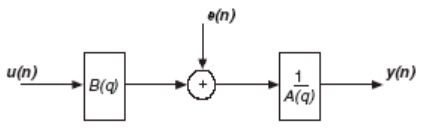 <br>
sysARX = arx(data, [na, nb, nk]) ([link](https://se.mathworks.com/help/ident/ref/arx.html))
> na: Order of A(q)  <br>
> nb: Order of B(q)+1  <br>
> nk: Input-Output delay  <br>

### Set estimation options

In [78]:
opt = arxOptions;
opt.Focus = 'prediction';

### Coarse search model order

We cam use **[arxstruc()](https://se.mathworks.com/help/ident/ref/arxstruc.html)** and **[selstruc()](https://se.mathworks.com/help/ident/ref/selstruc.html)** to find a suggested ARX model structure
* arxstruc(estimation_data, validation_data, range )
> range = [na nb nk] <br>
> is the selected range of na, nb, nk <br>
> Ex: V = arxstruc(ze, zv, struc( 1:10, 1:10, 1:5 ));
* selstruc(arxstruc, 'criterion' )
> Ex: Order = selstruc(V,'aic'); <br>
> Find the best ARX model order based on Arkaike's Information Criterion 


In [79]:
range = struc(1:10, 1:10, 1:5);
V = arxstruc(data_train, data_test, range);
Order = selstruc(V, 'aic')


Order =

     2     5     1




### Estimate ARX model

In [80]:
sysARX = arx(data_train, [2 5 1])


sysARX =
Discrete-time ARX model: A(z)y(t) = B(z)u(t) + e(t)                      
  A(z) = 1 - 0.6428 z^-1 - 0.2878 z^-2                                   
                                                                         
  B(z) = -5.551 z^-1 + 6.502 z^-2 + 0.7219 z^-3 + 1.402 z^-4 - 3.021 z^-5
                                                                         
Sample time: 0.002 seconds
  
Parameterization:
   Polynomial orders:   na=2   nb=5   nk=1
   Number of free coefficients: 7
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                    
Estimated using ARX on time domain data "mini_batch_train".
Fit to estimation data: 69.86% (prediction focus)          
FPE: 41.78, MSE: 37.64                                     



### Advice on the estimated model

In [81]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 70; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARX Model

#### Goodness of Fit

In [82]:
% generate reference output
y_arx_ref = data_train.y;

% generate estimated output
y_arx_est = sim(sysARX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_arx_est.y, y_arx_ref, cost_func)


fit =

    1.6066




#### Compare

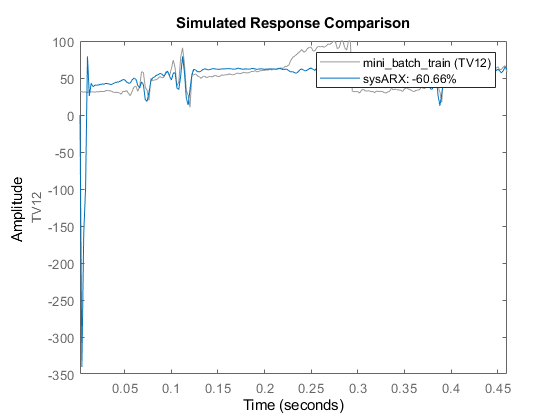

In [83]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

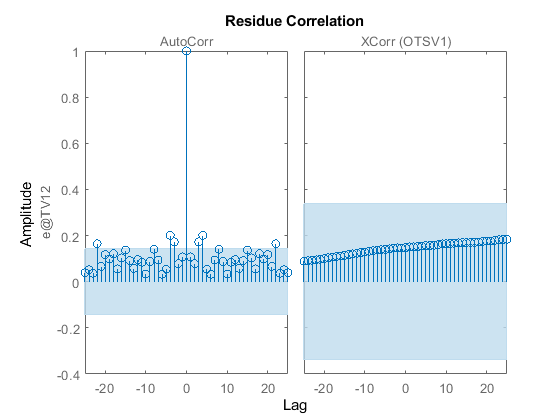

In [84]:
resid(data_test,sysARX)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

## System Identification: ARMAX Model

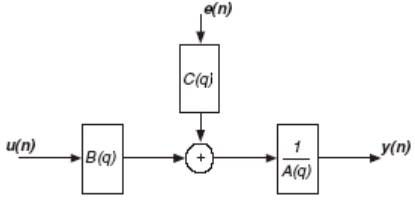 <br>
sysARMAX = armax(data, [na nb nc nk]) ([link](https://se.mathworks.com/help/ident/ref/armax.html))
> na: Order of A(q)  <br>
> nb: Order of B(q)+1  <br>
> nc: Order of C(q)  <br>
> nk: Input-Output delay

### Set estimation options

In [85]:
opt = armaxOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 100;
opt.SearchOptions.Tolerance = 1e-5;

### Estimate ARMAX model

In [88]:
na = 9;
nb = 9;
nc = 9;
nk = 0;
sysARMAX = armax(data_train, [na nb nc nk], opt)


sysARMAX =
Discrete-time ARMAX model: A(z)y(t) = B(z)u(t) + C(z)e(t)                                                                 
                                                                                                                          
  A(z) = 1 - 0.3319 z^-1 - 1.264 z^-2 - 0.3016 z^-3 + 0.7046 z^-4 + 0.6124 z^-5 - 0.4878 z^-6 - 0.1397 z^-7 + 0.342 z^-8  
                                                                                                            - 0.108 z^-9  
                                                                                                                          
                                                                                                                          
B(z) = -1.609 - 3.849 z^-1 + 4.292 z^-2 + 8.622 z^-3 - 0.09634 z^-4 - 8.016 z^-5 - 5.968 z^-6 + 6.822 z^-7 - 0.1771 z^-8  
                                                                                                                          
    

### Advice on the estimated model

In [72]:
advice(sysARMAX, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 70; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARMAX Model

#### Goodness of Fit

In [90]:
% generate reference output
y_armax_ref = data_train.y;

% generate estimated output
y_armax_est = sim(sysARMAX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_armax_est.y, y_armax_ref, cost_func)


fit =

    2.4299




#### Compare

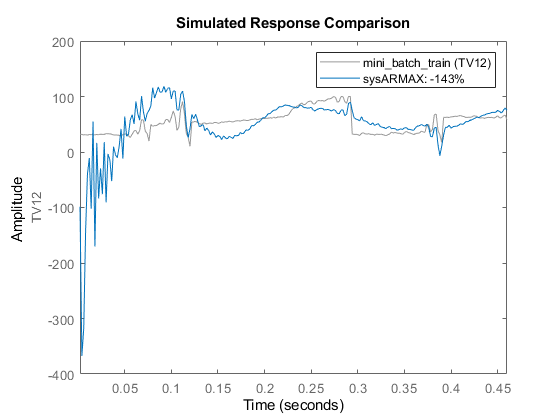

In [91]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARMAX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

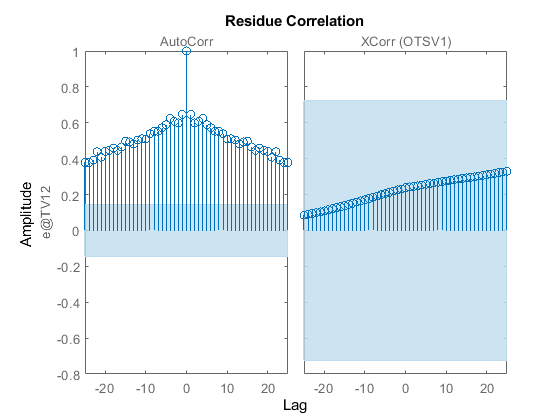

In [94]:
resid(data_test, sysARMAX)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

## System Identification: BJ Model

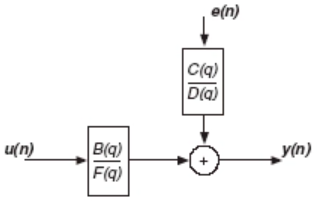 <br>
sysBJ = bj(data, [nb nc nd nf nk]) ([link](https://se.mathworks.com/help/ident/ref/bj.html))
> nb: Order of B(q)+1  <br>
> nc: Order of C(q)+1  <br>
> nd: Order of D(q)+1  <br>
> nf: Order of F(q)+1  <br>
> nk: Input-Output delay

### Set estimation options

In [57]:
opt = bjOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 100;
opt.SearchOptions.Tolerance = 1e-5;

### Coarse search model order

### Estimate ARX model

In [58]:
nb = 2;
nc = 2;
nd = 2;
nf = 2;
nk = 1;

sysBJ = bj(data_train, [nb nc nd nf nk], opt)


sysBJ =
Discrete-time BJ model: y(t) = [B(z)/F(z)]u(t) + [C(z)/D(z)]e(t)
  B(z) = 0.04058 z^-1 - 0.03768 z^-2                            
                                                                
  C(z) = 1 - 0.03947 z^-1 - 0.3303 z^-2                         
                                                                
  D(z) = 1 - 1.772 z^-1 + 0.7795 z^-2                           
                                                                
  F(z) = 1 - 1.785 z^-1 + 0.7874 z^-2                           
                                                                
Sample time: 10 seconds
  
Parameterization:
   Polynomial orders:   nb=2   nc=2   nd=2   nf=2   nk=1
   Number of free coefficients: 8
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                   
Estimated using BJ on time domain data "mini_batch_train".
Fit to estimation data: 90.02% (prediction focus)         
FPE: 0.5308, 

### Advice on the estimated model

In [59]:
advice(sysBJ, data_test)

                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysBJ.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 110; 
   sysBJ = pem(sysBJ, mini_batch_train, Options)
                                                                                                                                                                                                                              
There is no indication of significant errors in the model dynamics.                                                                                                                                                           
                                                                                                            

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARX Model

#### Goodness of Fit

In [60]:
% generate reference output
y_bj_ref = data_train.y;

% generate estimated output
y_bj_est = sim(sysBJ, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_bj_est.y, y_bj_ref, cost_func)


fit =

    4.8984




#### Compare

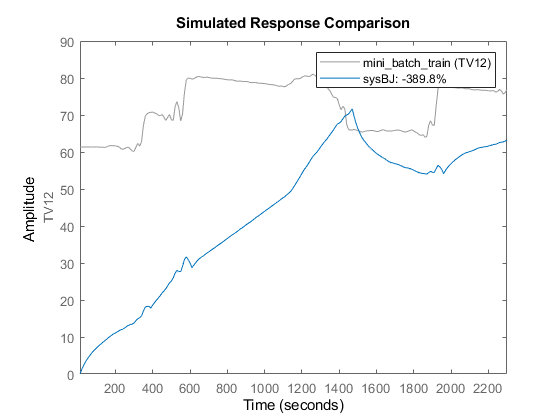

In [61]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysBJ, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

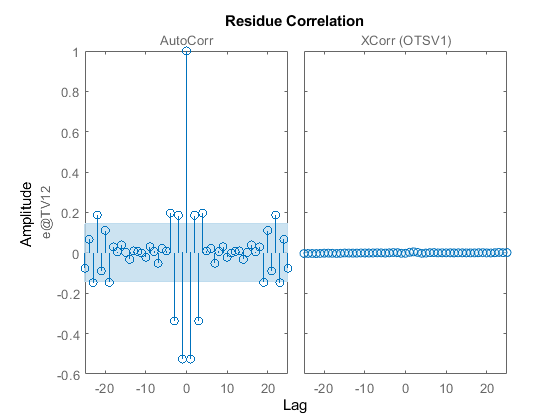

In [62]:
resid(data_test, sysBJ)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value